In [ ]:
# since most configuration are very similar, this notebook is used to run different configuration by override a few parameters

In [3]:
# set the current working directory
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('/Users/cgu3/Documents/Grape-Pi')

# Sensitivity analysis

For the sensitivity analysis to test using interaction with difference confidence threshold:150 (low), 400 (medium), 700 (high), and 0.9 (highest)
with different layer_type: GCNConv and SAGEConv
different column: protein_probability and combined_score

In [50]:
!python main.py  --config-path configs/protein --config-name grapepi_gcnconv

Rebuilding...
Done!
GCNConvGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): Dropout(p=0.3, inplace=False)
          (1): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): GCNConv(
          (model): GCNConv(10, 10)
        )
        (post_layer): Sequential(
          (0): Dropout(p=0.3, inplace=False)
          (1): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 1

In [202]:
confidence_threshold = [150.0, 400.0, 700.0, 900.0]
layer_type = ['grapepi_gcnconv', 'grapepi_sageconv']

# create a list of configurations
configs = []
for threshold in confidence_threshold:
    for layer in layer_type:
        config = f'{layer}_thresh_{threshold}'
        configs.append(config)

configs

['grapepi_gcnconv_thresh_150.0',
 'grapepi_sageconv_thresh_150.0',
 'grapepi_gcnconv_thresh_400.0',
 'grapepi_sageconv_thresh_400.0',
 'grapepi_gcnconv_thresh_700.0',
 'grapepi_sageconv_thresh_700.0',
 'grapepi_gcnconv_thresh_900.0',
 'grapepi_sageconv_thresh_900.0']

In [203]:
import os
import pandas as pd
import json

# Initialize an empty list to store the data
data_list = []

# Loop through each folder and read the JSON file
for folder in configs:
    file_path = os.path.join('results', folder, '1234', 'test', 'stats.json')
    with open(file_path, 'r') as file:
        data = json.loads(file.read())
        data['folder'] = folder  # Add the folder name as a new column
        data_list.append(data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

   epoch    loss     lr  params  time_iter  accuracy  precision  recall  \
0    300  0.6166  0.001     141     4.7883    0.8154     0.7030  0.8741   
1    110  0.4816  0.001     241     4.7916    0.8449     0.7933  0.7719   
2    300  0.6169  0.001     141     4.4994    0.8142     0.7076  0.8549   
3    146  0.4795  0.001     241     4.5797    0.8441     0.7942  0.7676   
4    300  0.6330  0.001     141     4.3650    0.7975     0.6904  0.8282   
5    131  0.4991  0.001     241     4.5139    0.8281     0.7594  0.7676   
6    300  0.6367  0.001     141     4.7825    0.7908     0.6761  0.8420   
7    161  0.4755  0.001     241     4.6228    0.8374     0.7825  0.7622   

       f1     auc                         folder  
0  0.7793  0.9150   grapepi_gcnconv_thresh_150.0  
1  0.7825  0.9007  grapepi_sageconv_thresh_150.0  
2  0.7743  0.9016   grapepi_gcnconv_thresh_400.0  
3  0.7806  0.9028  grapepi_sageconv_thresh_400.0  
4  0.7530  0.8864   grapepi_gcnconv_thresh_700.0  
5  0.7634  0.8965 

In [204]:
df[['layer_type', 'threshold']] = df['folder'].str.extract(r'grapepi_(gcnconv|sageconv)_thresh_(\d{3,4})')

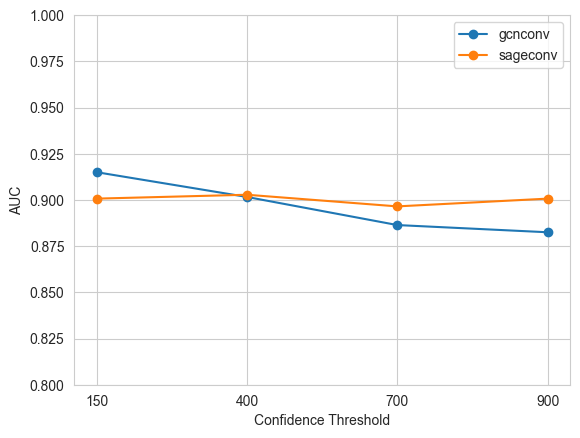

In [205]:
# plot with threshold at x-axis and layer_type as group by color. AUC as value in y-axis
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots()
for layer, group in df.groupby('layer_type'):
    ax.plot(group['threshold'], group['auc'], marker='o', label=layer)
# change y-axis range
ax.set_ylim(0.8, 1)
# set x-axis label
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('AUC')
ax.legend()
plt.show()


In [130]:
!python grape_pi.py --cfg results/grapepi_sageconv_thresh_150.0/config.yaml --checkpoint results/grapepi_sageconv_thresh_150.0/1234/ckpt/epoch=109-step=10560.ckpt --output results/grapepi_sageconv_thresh_150.0/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_protein_data(result, label_col, unconfident_threshold, title):
    dat = pd.read_csv(result)
    dat = dat.loc[:, ['accession', 'gene_symbol', 'pred_prob', 'protein_probability', label_col, 'mRNA_TPM']]
    dat.rename(columns={'protein_probability': 'raw_prob', 'mRNA_TPM': 'mRNA'}, inplace=True)
    output_dir = os.path.dirname(result)
    output = os.path.join(output_dir, 'mRNA_coverage.tiff')

    dat = dat[dat[label_col].isnull()]
    dat = dat[(dat['raw_prob'] < unconfident_threshold)]
    dat['mRNA'] = dat['mRNA'].apply(lambda x: 1 if x > 0 else 0)

    pred_prob_preded_mRNA_coverage = []
    raw_prob_preded_mRNA_coverage = []
    for N in range(100, dat.shape[0], 1):
        positive_by_pred = dat.sort_values(by='pred_prob', ascending=False).reset_index(drop=True).iloc[:N, dat.columns.get_loc('mRNA')]
        positive_by_raw = dat.sort_values(by='raw_prob', ascending=False).reset_index(drop=True).iloc[:N, dat.columns.get_loc('mRNA')]

        pred_prob_preded_mRNA_coverage.append(np.sum(positive_by_pred) / len(positive_by_pred))
        raw_prob_preded_mRNA_coverage.append(np.sum(positive_by_raw) / len(positive_by_raw))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(pred_prob_preded_mRNA_coverage)
    ax.plot(raw_prob_preded_mRNA_coverage)
    ax.set_xlabel('Number of proteins predicted to be positive')
    ax.set_xlim(0, dat.shape[0])
    ax.set_xticks(range(0, dat.shape[0], 500))
    ax.set_ylabel('Proportion of proteins with detected corresponding mRNA')
    plt.legend(['Predicted protein probability', 'Raw protein probability'])
    plt.title(title)
    plt.show()
    fig.savefig(output, format='tiff', dpi=350, bbox_inches='tight')

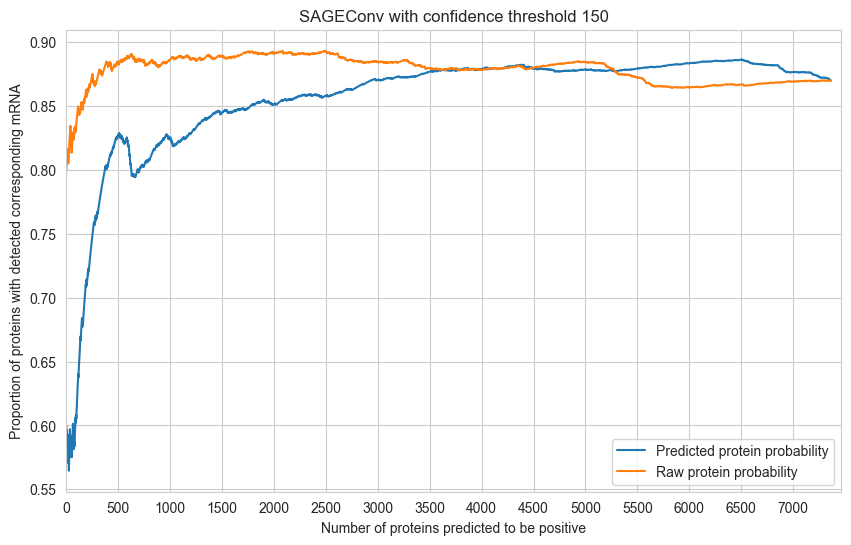

In [11]:
plot1 = analyze_protein_data('results/grapepi_sageconv_thresh_150.0/evaluation/all_proteins.csv', label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with confidence threshold 150')

In [132]:
!python grape_pi.py --cfg results/grapepi_sageconv_thresh_400.0/config.yaml --checkpoint results/grapepi_sageconv_thresh_400.0/1234/ckpt/epoch=145-step=14016.ckpt --output results/grapepi_sageconv_thresh_400.0/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

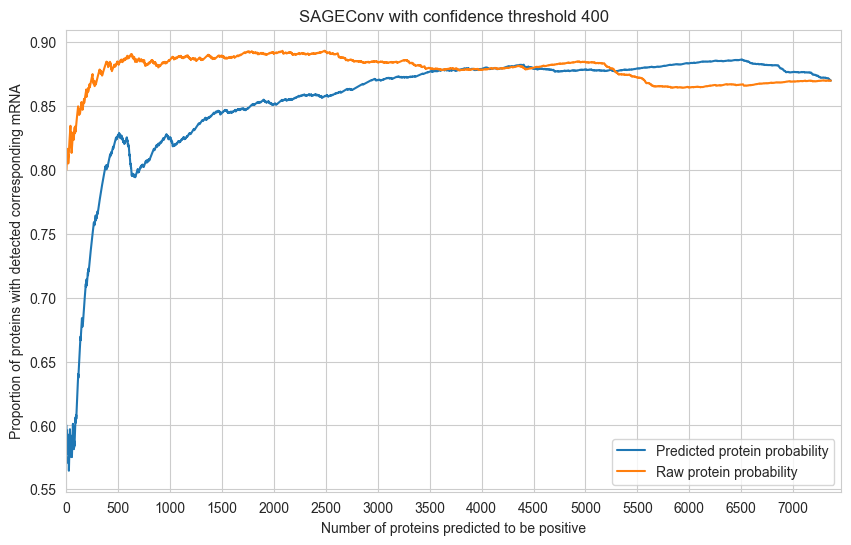

In [12]:
plot2 = analyze_protein_data('results/grapepi_sageconv_thresh_400.0/evaluation/all_proteins.csv', label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with confidence threshold 400')

In [134]:
!python grape_pi.py --cfg results/grapepi_sageconv_thresh_700.0/config.yaml --checkpoint results/grapepi_sageconv_thresh_700.0/1234/ckpt/epoch=130-step=12576.ckpt --output results/grapepi_sageconv_thresh_700.0/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

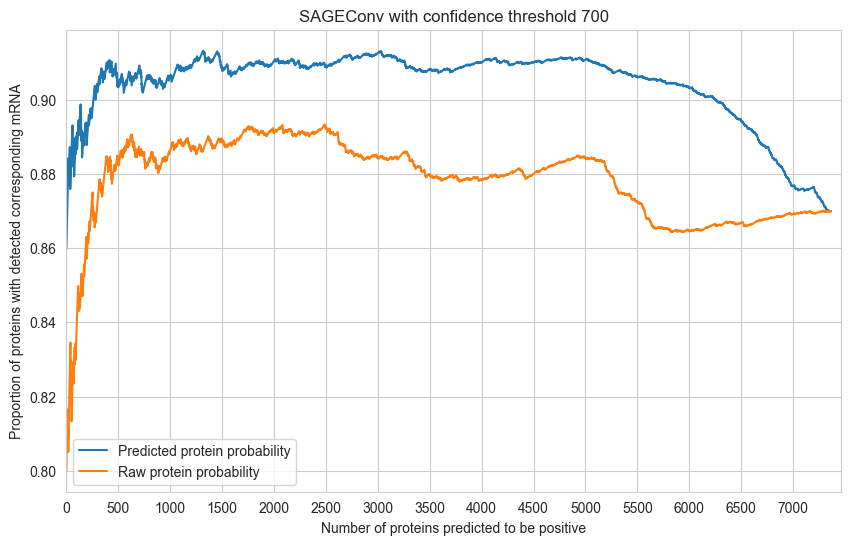

In [169]:
plot3 = analyze_protein_data('results/grapepi_sageconv_thresh_700.0/evaluation/all_proteins.csv', label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with confidence threshold 700')

In [136]:
!python grape_pi.py --cfg results/grapepi_sageconv_thresh_900.0/config.yaml --checkpoint results/grapepi_sageconv_thresh_900.0/1234/ckpt/epoch=160-step=15456.ckpt --output results/grapepi_sageconv_thresh_900.0/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

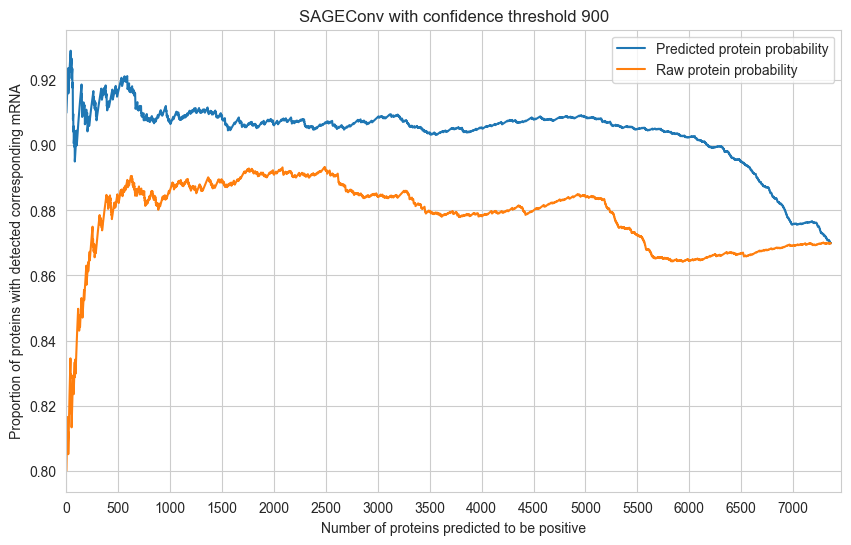

In [168]:
 analyze_protein_data('results/grapepi_sageconv_thresh_900.0/evaluation/all_proteins.csv', label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with confidence threshold 900')

# Sensitivity analysis for different criterion for labeling

Testing case with different label column: hard_label_02_08, hard_label_03_07, and hard_label_04_06 under medium confidence threshold with SAGEConv, GCNConv, and MLP model. In total 9 different configurations

In [81]:
import pandas as pd

dat = pd.read_csv('data/gastric_all_data/raw/protein/gastric_all_data.csv')
dat

,protein,protein_probability,mRNA,y
0,YNR077C,0.00,0.13,0
1,YDR444W,0.96,0.15,0
2,YHR213W,0.00,0.16,0
3,YLR465C,0.00,0.16,0
4,YDR543C,0.00,0.18,0
...,...,...,...,...
3204,YKL152C,1.00,122.05,1
3205,YDL184C,0.00,125.56,0
3206,YLR044C,1.00,138.72,1
3207,YKL060C,1.00,153.36,1


In [82]:
from sklearn.metrics import roc_auc_score

for hard_label in ['hard_label_04_06', 'hard_label_03_07', 'hard_label_02_08']:
    labeled = ~dat[hard_label].isnull()
    raw = dat[hard_label][labeled]
    true = dat['protein_probability'][labeled]
    # calcualte AUC between raw and true
    auc = round(roc_auc_score(raw, true), 3)
    print(auc)

KeyError: 'hard_label_04_06'

In [198]:
import os
import pandas as pd
import json

# List of data folders
data_folders = [
    'grapepi_sageconv_label_hard_label_04_06',
    'grapepi_sageconv_label_hard_label_03_07',
    'grapepi_sageconv_label_hard_label_02_08',
    'grapepi_gcnconv_label_hard_label_04_06',
    'grapepi_gcnconv_label_hard_label_03_07',
    'grapepi_gcnconv_label_hard_label_02_08'
]

# Initialize an empty list to store the data
data_list = []

# Loop through each folder and read the JSON file
for folder in data_folders:
    file_path = os.path.join('results', folder, '1234', 'test', 'stats.json')
    with open(file_path, 'r') as file:
        data = json.loads(file.read())
        data['folder'] = folder  # Add the folder name as a new column
        data_list.append(data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

   epoch    loss     lr  params  time_iter  accuracy  precision  recall  \
0    126  0.5761  0.001     241     5.5033    0.8179     0.7517  0.6981   
1    146  0.4810  0.001     241     4.4793    0.8421     0.7891  0.7686   
2    164  0.3617  0.001     241     4.8420    0.8811     0.8910  0.8034   
3    300  0.6875  0.001     141     4.5948    0.7709     0.6459  0.8013   
4    300  0.6165  0.001     141     5.1928    0.8138     0.7070  0.8549   
5    300  0.5327  0.001     141     4.9850    0.8526     0.7862  0.8926   

       f1     auc                                   folder  
0  0.7239  0.8692  grapepi_sageconv_label_hard_label_04_06  
1  0.7788  0.9029  grapepi_sageconv_label_hard_label_03_07  
2  0.8449  0.9297  grapepi_sageconv_label_hard_label_02_08  
3  0.7153  0.8582   grapepi_gcnconv_label_hard_label_04_06  
4  0.7739  0.9006   grapepi_gcnconv_label_hard_label_03_07  
5  0.8361  0.9290   grapepi_gcnconv_label_hard_label_02_08  


In [199]:
import numpy as np
df[['conv_type', 'label']] = df['folder'].str.extract(r'grapepi_(sageconv|gcnconv)_label_(hard_label_\d{2}_\d{2})')
df

,epoch,loss,lr,params,time_iter,accuracy,precision,recall,f1,auc,folder,conv_type,label
0,126,0.5761,0.001,241,5.5033,0.8179,0.7517,0.6981,0.7239,0.8692,grapepi_sageconv_label_hard_label_04_06,sageconv,hard_label_04_06
1,146,0.4810,0.001,241,4.4793,0.8421,0.7891,0.7686,0.7788,0.9029,grapepi_sageconv_label_hard_label_03_07,sageconv,hard_label_03_07
2,164,0.3617,0.001,241,4.8420,0.8811,0.8910,0.8034,0.8449,0.9297,grapepi_sageconv_label_hard_label_02_08,sageconv,hard_label_02_08
3,300,0.6875,0.001,141,4.5948,0.7709,0.6459,0.8013,0.7153,0.8582,grapepi_gcnconv_label_hard_label_04_06,gcnconv,hard_label_04_06
4,300,0.6165,0.001,141,5.1928,0.8138,0.7070,0.8549,0.7739,0.9006,grapepi_gcnconv_label_hard_label_03_07,gcnconv,hard_label_03_07
5,300,0.5327,0.001,141,4.9850,0.8526,0.7862,0.8926,0.8361,0.9290,grapepi_gcnconv_label_hard_label_02_08,gcnconv,hard_label_02_08


In [200]:
# add a new column with auc 0.846, label_08, conv_type='raw'
row1 = {'auc': 0.797, 'label': 'hard_label_04_06', 'conv_type':'raw'}
row2 = {'auc':0.846, 'label': 'hard_label_02_08', 'conv_type': "raw"}
row3 = {'auc': 0.821, 'label': 'hard_label_03_07', 'conv_type': "raw"}

new_rows = pd.DataFrame([row1, row2, row3])
df = pd.concat([df, new_rows], ignore_index=True)

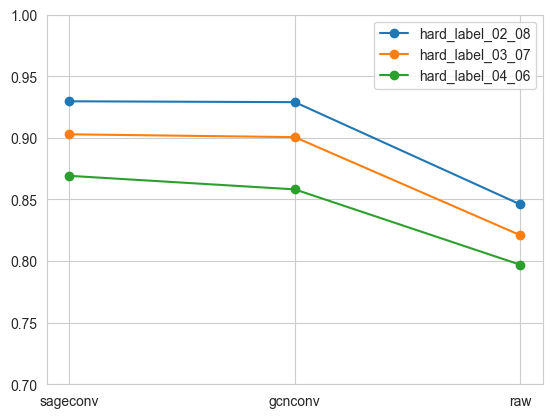

In [201]:
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots()
for label, group in df.groupby('label'):
    ax.plot(group['conv_type'], group['auc'], marker='o', label=label)
ax.set_ylim(0.7, 1)
ax.legend()
plt.show()


# mRNA coverage result for SAGEConv with different confidence threshold

In [211]:
# todo: need to add slient option to mute the output
!python grape_pi.py --cfg results/grapepi_sageconv_label_hard_label_02_08/config.yaml --checkpoint results/grapepi_sageconv_label_hard_label_02_08/1234/ckpt/epoch=163-step=15744.ckpt --output results/grapepi_sageconv_label_hard_label_02_08/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

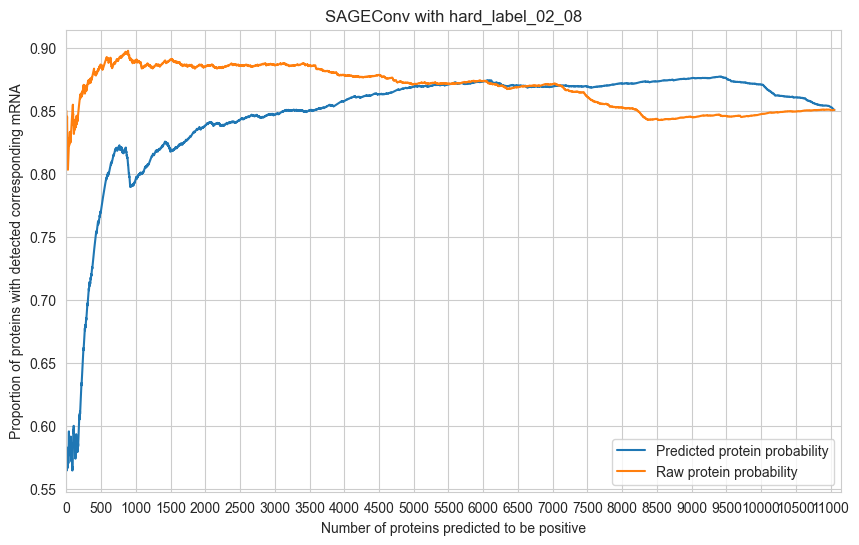

In [14]:
analyze_protein_data('results/grapepi_sageconv_label_hard_label_02_08/evaluation/all_proteins.csv', label_col='hard_label_02_08', unconfident_threshold=0.9, title='SAGEConv with hard_label_02_08')

In [218]:
!python grape_pi.py --cfg results/grapepi_sageconv_label_hard_label_04_06/config.yaml --checkpoint results/grapepi_sageconv_label_hard_label_04_06/1234/ckpt/epoch=125-step=12096.ckpt --output results/grapepi_sageconv_label_hard_label_04_06/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

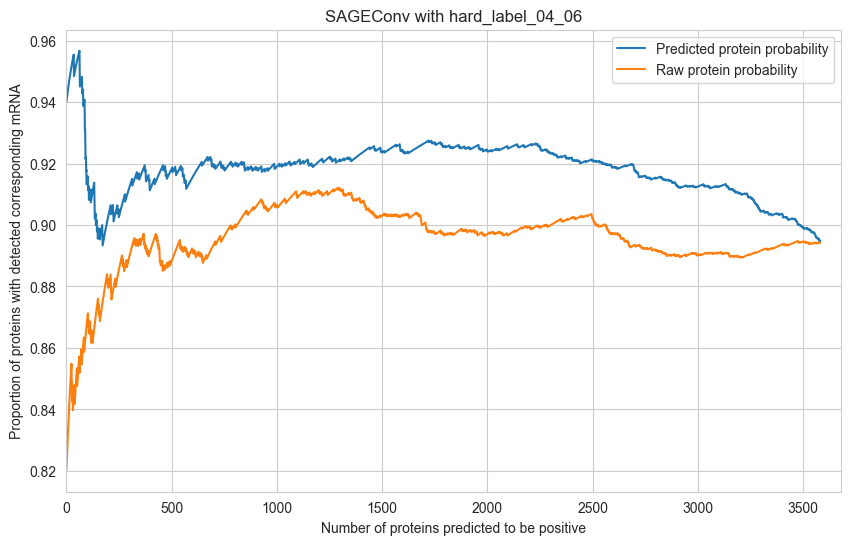

In [219]:
analyze_protein_data('results/grapepi_sageconv_label_hard_label_04_06/evaluation/all_proteins.csv', 
                     label_col='hard_label_04_06', unconfident_threshold=0.9, title='SAGEConv with hard_label_04_06')

In [23]:
!python grape_pi.py --cfg results/grapepi_sageconv_label_hard_label_03_07/config.yaml --output results/grapepi_sageconv_label_hard_label_03_07/evaluation

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): SAGEConv(
          (model): SAGEConv(10, 10, aggr=mean)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_

In [9]:
analyze_protein_data('results/grapepi_sageconv_label_hard_label_03_07/evaluation/all_proteins.csv',
                     label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with hard_label_03_07')

NameError: name 'analyze_protein_data' is not defined

# Calculate auc from raw data for yeast

In [83]:
from grape_pi import ProteinDataset

In [95]:
dataset_yeast_LCQ = ProteinDataset('data/yeast-LCQ', node_numeric_cols=['protein_probability'], rebuild=True)
dataset_yeast_ORBI = ProteinDataset('data/yeast-ORBI', node_numeric_cols=['protein_probability'], rebuild=True)

Rebuilding...
Done!
Rebuilding...
Done!


In [101]:
auc_yeast_LCQ = roc_auc_score(dataset_yeast_LCQ._data.y, dataset_yeast_LCQ._data.x)
auc_yeast_ORBI = roc_auc_score(dataset_yeast_ORBI._data.y, dataset_yeast_ORBI._data.x)
print("AUC for yeast-LCQ: ", auc_yeast_LCQ)
print("AUC for yeast-ORBI: ", auc_yeast_ORBI)

AUC for yeast-LCQ:  0.6256950862236975
AUC for yeast-ORBI:  0.8361260553994329


# Run with embedding

In [6]:
!python grape_pi.py --cfg configs/protein/grapepi_sageconv.yaml  --output results/grapepi_sageconv_with_embedding/evaluation --override "run.name=grapepi_sageconv_with_embedding dataset.include_seq_embedding=True gnn.layers_mp=0"

GraphsageGraphGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 128
  edge_encoder: False
  edge_encoder_bn: True
  edge_encoder_name: Bond
  edge_message_ratio: 0.8
  edge_negative_sampling_ratio: 1.0
  edge_numeric_cols: None
  edge_train_mode: all
  encoder: True
  encoder_bn: True
  encoder_dim: 128
  encoder_name: db
  format: PyG
  include_seq_embedding: True
  inte

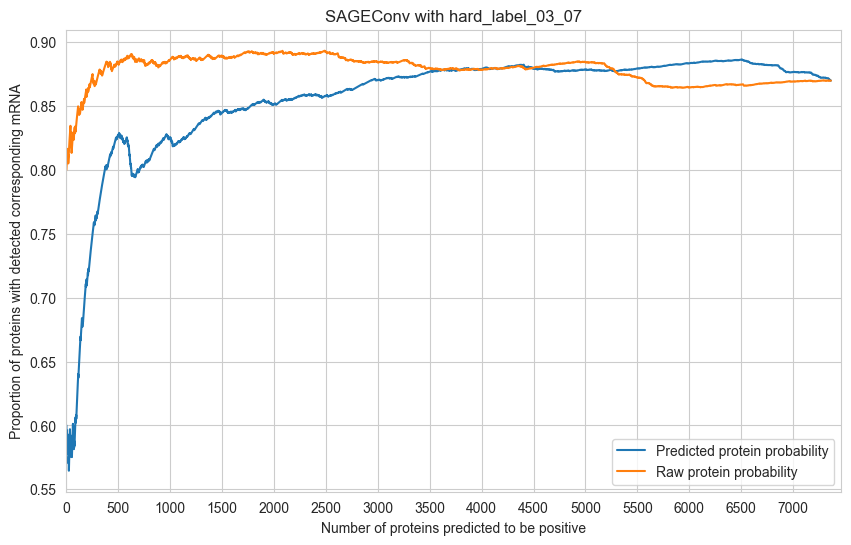

In [13]:
analyze_protein_data('results/grapepi_sageconv_with_embedding/all_proteins.csv',
                     label_col='hard_label_03_07', unconfident_threshold=0.9, title='SAGEConv with hard_label_03_07')

In [ ]:
!python grape_pi.py --cfg configs/protein/grapepi_sageconv.yaml --checkpoint results/grapepi_sageconv_with_embedding/1234/ckpt/epoch=69-step=6720.ckpt --output results/grapepi_sageconv_with_embedding/evaluation --override "run.name=grapepi_sageconv_with_embedding dataset.include_seq_embedding=True"